In [2]:
import numpy as np
import pandas as pd
import string
import calendar
import re
import math
import sympy
import matplotlib.pyplot as plt
import pprint

from fractions import Fraction
from scipy import stats
from scipy import special


print(f"numpy version is {np.__version__}")
print(f"pandas version is {pd.__version__}")


numpy version is 1.20.3
pandas version is 1.3.1


#### Manual formatting of raw data

In [2]:
# Intensive formatting using regex

# text1 = open('transistorLives.txt', 'r')
# f1 = open('newTransistor.txt', 'w')
# outFile = []
# for line in text1:
#     a = re.sub("\.", " ", line)
#     b = ' '.join(a.split())
#     c = re.sub(" (?=[A-Za-z])", "_", b)
#     f1.write(c)
#     f1.write('\n')
# f1.close()

# Simple formatting using reshape

# oldArr = np.loadtxt('transistorLives.txt')
# newArr = np.reshape(oldArr, [-1, 3])
# np.savetxt('newTransistor.txt', newArr, delimiter = ' ')

# transofrming to linearity 

# oldArr = np.loadtxt('transistorLives.txt')
# newArr = np.hstack((oldArr[:, 0], np.log(oldArr[:, 1])))
# # newArr[[1, 0], :] = newArr[[0, 1], :]
# print(newArr)
# np.savetxt('newTransistor.txt', newArr, delimiter = ' ')


oldArr = pd.read_csv('transistorLives.txt', thousands=',', sep = ' ', header=None)
oldArr[1] = np.log(oldArr[1])
oldArr.to_csv('newTransistor.txt', header=False, index = False, sep = ' ')

FileNotFoundError: [Errno 2] No such file or directory: 'transistorLives.txt'

#### Linear Simple Regression

In [53]:
df = pd.DataFrame(np.loadtxt('transistorLives.txt'), columns=['Daily cars', 'Monthly accidents'])
# df = pd.read_csv('newTransistor.txt', sep=' ', thousands=',', header=None, names=['Days', 'Log Bacterial count'])

# df = pd.DataFrame(np.loadtxt('transistorLives.txt'), columns=['Percentage', 'Reading'])
df = df.sort_values(by = df.columns[0])
# df = df[df['Cigarette consumption'] > 2300]

print(df, '\n')

# non-weighted linear regression
r1 = stats.linregress(df.iloc[:, 0], df.iloc[:, 1])
s1 = pd.Series(r1._asdict())
print(s1)

   Daily cars  Monthly accidents
0         5.0             0.0000
1        10.0             0.0090
2        15.0             0.0185
3        20.0             0.0672
4        25.0             0.1542
5        30.0             0.1720
6        35.0             0.1840
7        40.0             0.2105
8        45.0             0.3570
9        50.0             0.4545 

slope               0.009521
intercept          -0.099133
rvalue              0.953112
pvalue              0.000020
stderr              0.001069
intercept_stderr    0.033158
dtype: float64


#### Least squares estimators of $\beta_0$ and $\beta_1$

In [27]:
S_xY = ((df.iloc[:, 0] - df.iloc[:, 0].mean()) * df.iloc[:, 1]).sum()
S_xx = (df.iloc[:, 0]**2).sum() - df.shape[0] * df.iloc[:, 0].mean()**2
S_YY = (df.iloc[:, 1]**2).sum() - df.shape[0] * df.iloc[:, 1].mean()**2

B = S_xY / S_xx
A = df.iloc[:, 1].mean() - B * df.iloc[:, 0].mean()
residuals = df.iloc[:, 1] - A - B*df.iloc[:, 0]
SS_R = (residuals ** 2).sum()
varY = SS_R / (df.shape[0] - 2)
print(f'Least squares estimators A = {A} and B = {B}')

Least squares estimators A = -6.83821027560402 and B = 0.010936543041850991


#### Least squares estimator forcing pass through origin

In [201]:
A = 0
B = (df.iloc[:, 0] * df.iloc[:, 1]).sum() / (df.iloc[:, 0] ** 2).sum()
print(f'Forcing pass through origin, B = {B}')

Forcing pass through origin, B = 1.6804688572646103


#### confidence interval for variance of response $\sigma^2$

In [202]:
alpha = 0.95
# highVal, lowVal = stats.chi2.ppf(0.05,8), stats.chi2.ppf(0.95, 8)
highVal, lowVal = stats.chi2.ppf((1 - alpha)/2, df.shape[0] - 2), stats.chi2.ppf((1 + alpha)/2, df.shape[0] - 2)
print(f'SS_R = {SS_R} and variance in response = {varY}')
print(f'confidence interval for alpha = {alpha} is [{SS_R / lowVal}, {SS_R / highVal}]')

SS_R = 0.19146357051683932 and variance in response = 0.06382119017227977
confidence interval for alpha = 0.95 is [0.020480884075731842, 0.8872463206275666]


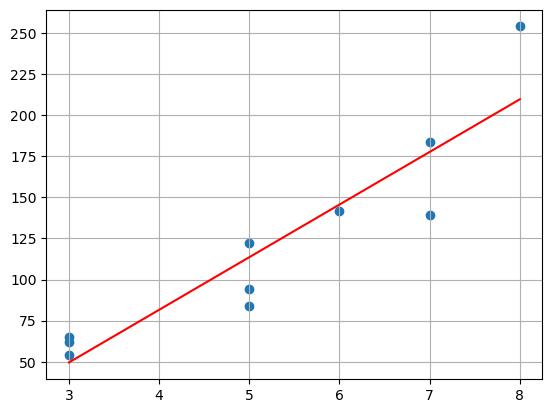

In [366]:
ax1 = plt.scatter(df.iloc[:, 0], df.iloc[:, 1]);
plt.plot(df.iloc[[0, -1], 0], r1.intercept + r1.slope*df.iloc[[0, -1], 0], 'red')

plt.grid();
plt.show()


In [204]:
# printint and formatting into plug and play latex booktabs
pr1 = s1[0:4].to_latex(header=['LinRegressOutput'], column_format='@{}rr@{}')
pr1 = pr1.replace('{} & LinRegressOutput ', '\multicolumn{2}{c}{\\texttt{linRegressOutput}} ')
pr1 = pr1.replace('slope', '$\\beta_1$').replace('intercept', '$\\beta_0$').replace('rvalue', '$r$').replace('pvalue', '$p$')
print('\\begin{figure}[H]')
print('\\begin{subfigure}[]{0.2\\linewidth}')
print('\\centering')
print(pr1)
print('\\end{subfigure}\n','%\n','\\begin{subfigure}[]{0.8\\linewidth}\n', '\\centering\n')

# printing in latex format the figure
print('\\begin{tikzpicture}')

string1 = f'xlabel={df.columns[0]}, ylabel={df.columns[1]}'
string2 = f'{r1.slope.round(4)}*x + {r1.intercept.round(4)}'
string3 = f'{df.iloc[:, 0].min()}:{df.iloc[:, 0].max()}'
    
print('\\begin{axis}[width = 0.75\\textwidth,' + string1 + ', grid=both, title = {$y = \\beta_0 + \\beta_1 x$}]')
print('\\addplot[thick, smooth, draw=blue][domain=' + string3 + ']{' + string2 + '};')
print('\\addplot[only marks, color = red] plot coordinates{', end = '')
print(*list(zip(df.iloc[:, 0], df.iloc[:, 1])), end = '')
print('};')
print('\\end{axis}')
print('\\end{tikzpicture}')
print('\\end{subfigure}')
print('\\end{figure}')

\begin{figure}[H]
\begin{subfigure}[]{0.2\linewidth}
\centering
\begin{tabular}{@{}rr@{}}
\toprule
\multicolumn{2}{c}{\texttt{linRegressOutput}} \\
\midrule
$\beta_1$     &         0.150773 \\
$\beta_0$ &        11.078703 \\
$r$    &         0.845975 \\
$p$    &         0.070863 \\
\bottomrule
\end{tabular}

\end{subfigure}
 %
 \begin{subfigure}[]{0.8\linewidth}
 \centering

\begin{tikzpicture}
\begin{axis}[width = 0.75\textwidth,xlabel=Days, ylabel=Log Bacterial count, grid=both, title = {$y = \beta_0 + \beta_1 x$}]
\addplot[thick, smooth, draw=blue][domain=3:9]{0.1508*x + 11.0787};
\addplot[only marks, color = red] plot coordinates{(3, 11.703545824578878) (6, 11.805595078933049) (7, 11.898187865760873) (8, 12.254862809699606) (9, 12.706847933442663)};
\end{axis}
\end{tikzpicture}
\end{subfigure}
\end{figure}


In [207]:
# manSlope, manIntercept = 0.4, 0.159
# yVal = xVal * manSlope + manIntercept

xVal = np.array([8])
yVal = xVal * r1.slope + r1.intercept


pairs = ''
for item in list(zip(xVal, yVal)):
    pairs += str(item)
    
print(f'xVal = {xVal} and yVal = {yVal}')
print('\\addplot[only marks, color = ForestGreen] plot coordinates{', pairs ,'};' )

xVal = [8] and yVal = [12.28489066]
\addplot[only marks, color = ForestGreen] plot coordinates{ (8, 12.28489066408789) };


In [178]:
yVal1 = [0.5]

# xVal1 = (yVal1 - r1.intercept) / r1.slope
print(f'xVal1 = {xVal1} and yVal1 = {yVal1}')

pairs = ''
for item in list(zip(xVal1, yVal1)):
    pairs += str(item)
    
    
print('\\addplot[only marks, color = ForestGreen] plot coordinates{', pairs ,'};' )

xVal1 = 0.6580094746154788 and yVal1 = [0.5]


TypeError: 'numpy.float64' object is not iterable

#### Hypothesis testing on $\beta$

In [52]:
beta_0 = 0

testStat = math.sqrt((df.shape[0] - 2) * S_xx / SS_R) * abs(B - beta_0)
pVal_beta = 2 * (1 - stats.t.cdf(testStat, df.shape[0] - 2))
print(f'p value is {(100 * pVal_beta).round(2)} % for test statistic {testStat}')

p value is 0.01 % for test statistic 5.0306893938080695


#### Hypothesis testing on $\alpha$

In [9]:
alpha_0 = 1

testStat_alpha = math.sqrt(df.shape[0] * (df.shape[0] - 2) * S_xx / (SS_R * (df.iloc[:, 0]**2).sum())) * abs(A - alpha_0)
pVal_alpha = 2 * (1 - stats.t.cdf(testStat_alpha, df.shape[0] - 2))
print(f'p value is {(100 * pVal_alpha).round(2)} % for test statistic {testStat_alpha}')

p value is 3.46 % for test statistic 2.5413041240750505


#### Confidence interval for mean response $\alpha + \beta x_0$

In [211]:
x_0 = 8
pointEst = A + B * x_0
confidence = 95

interval = stats.t.ppf(0.005 * (100 + confidence), df.shape[0] - 2) * math.sqrt((SS_R / (df.shape[0] - 2)) * (0 + 1/df.shape[0] + ((x_0 - df.iloc[:, 0].mean())**2)/S_xx))
print(f'Prediction interval with confidence {confidence} % is [{pointEst - interval}, {pointEst + interval}]')
print(f'Point estimate is {pointEst} and half-interval size is {interval}')

stringErrbarY = f'({x_0}, {pointEst}) +- ({0}, {interval})'
print('\\addplot+[mark = *, error bars/.cd, y dir=both,y explicit] coordinates{', stringErrbarY,' };')

Prediction interval with confidence 95 % is [11.85010877154164, 12.719672556634146]
Point estimate is 12.284890664087893 and half-interval size is 0.43478189254625227
\addplot+[mark = *, error bars/.cd, y dir=both,y explicit] coordinates{ (8, 12.284890664087893) +- (0, 0.43478189254625227)  };


#### Prediction interval for new value at $x_0$

In [212]:
x_0 = 8
pointEst = A + B * x_0
confidence = 95

interval = stats.t.ppf(0.005 * (100 + confidence), df.shape[0] - 2) * math.sqrt((SS_R / (df.shape[0] - 2)) * (1 + 1/df.shape[0] + ((x_0 - df.iloc[:, 0].mean())**2)/S_xx))
print(f'Prediction interval with confidence {confidence} % is [{pointEst - interval}, {pointEst + interval}]')
print(f'Point estimate is {pointEst} and half-interval size is {interval}')

stringErrbarY = f'({x_0}, {pointEst}) +- ({0}, {interval})'
print('\\addplot+[mark = *, error bars/.cd, y dir=both,y explicit] coordinates{', stringErrbarY,' };')

Prediction interval with confidence 95 % is [11.370880794553479, 13.198900533622307]
Point estimate is 12.284890664087893 and half-interval size is 0.914009869534414
\addplot+[mark = *, error bars/.cd, y dir=both,y explicit] coordinates{ (8, 12.284890664087893) +- (0, 0.914009869534414)  };


#### Equality of variances of two datasets after linear regression separately

In [108]:
var_est_A, var_est_B = 6.56, 9.02
n, m = 5, 6

testStat_twoVar = (19.68928 / 6.56) / (36.09581 / 9.02) * ((m-2) / (n-2))

pVal_twoVar = 2*min(1 - stats.f.cdf(testStat_twoVar, n-2, m-2), stats.f.cdf(testStat_twoVar, n-2, m-2))

print(f'p-value for the equality of two variances is {100*pVal_twoVar} %')

p-value for the equality of two variances is 95.78753328526221 %


#### Plotting residuals

In [8]:
residuals_std = residuals / math.sqrt(SS_R / (residuals.shape[0] - 2))
plt.scatter(range(residuals.shape[0]), residuals_std)
plt.show()

print('\\begin{figure}[H]')
print('\\centering')
print('\\begin{tikzpicture}')
print('\\begin{axis}[width = 0.6\\textwidth, grid=both, title = {Residuals}]')
print('\\addplot[only marks, color = Plum] plot coordinates{', end = '')
print(*list(zip(range(residuals.shape[0]), residuals_std)), end = '')
print('};')
print('\\end{axis}')
print('\\end{tikzpicture}')
print('\\end{figure}')

NameError: name 'residuals' is not defined

#### Coefficient of determination two ways

In [118]:
print(f'The coefficient of determination using r-value is {r1.rvalue ** 2}')
print(f'The coefficient of determination using fundamentals is {1 - SS_R/S_YY}')
print('\n')
print(f'Sample correlation coefficient using linregress is {r1.rvalue}')
print(f'Sample correlation coefficient using fundamentals is {S_xY / math.sqrt(S_xx * S_YY)}')

The coefficient of determination using r-value is 0.9264669517643078
The coefficient of determination using fundamentals is 0.926466951764308


Sample correlation coefficient using linregress is -0.9625315328675252
Sample correlation coefficient using fundamentals is -0.9625315328675458


In [119]:
c1, m1 = math.pow(math.e, r1.slope), math.pow(math.e, r1.intercept)
print(f'transformed slope is {m1} and transofmred intercept is {c1}')

transformed slope is 1.9683901724425965e+21 and transofmred intercept is 4.568592927769246e-06


In [152]:
b1 = -r1.slope
a1 = math.pow(math.e, r1.intercept)
print(f'a is {a1} and b is {b1} ')

a is 1.7473427412980054 and b is 0.02389373339153227 


#### Validating the transformation to linearity

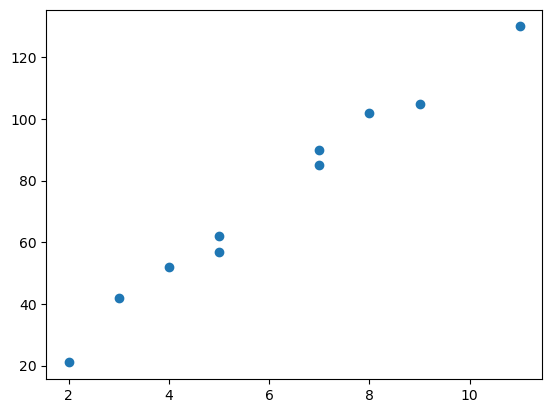

,0,1
0,2,21
1,3,42
2,8,102
3,11,130
4,4,52
5,5,57
6,9,105
7,7,85
8,5,62
9,7,90


In [7]:
rawData = pd.read_csv('transistorLives.txt', thousands = ',', header=None, sep=' ')
plt.scatter(rawData.iloc[:, 0], rawData.iloc[:, 1])
# xValsRaw = np.linspace(1, 500, 50501)
# plt.plot(xValsRaw, A1 / (xValsRaw ** m1), 'red')
# plt.plot(xValsRaw, 50.86 / (xValsRaw ** 0.0707), 'green')

plt.show()
rawData


### Polynomial Simple Regression

In [4]:
dfP = pd.read_csv('polyFitData.txt', sep=' ', thousands=',', header = None, )

# reformat imported dataframe 

# dfP = dfP.T
dfP.columns = ['Cars (daily)', 'Accidents (monthly)']
x, y = dfP.iloc[:, 0], dfP.iloc[:, 1]
M = np.array([])
K = np.array([])

dfP

plt.scatter(dfP.iloc[:, 0], dfP.iloc[:, 1])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'polyFitData.txt'

#### manual implementation of polynomial simple regression

In [66]:
deg = 2

M = np.array([])
K = np.array([])

for i in range(deg + 1):
#     M = np.append(M, (y * (x**i)).sum(), axis=None)
    M = np.vstack([M, (y * (x**i)).sum()]) if M.size else (y * (x**i)).sum()
    
    K_row = np.array([])
    for j in range(i, i+deg+1):
        K_row = np.append(K_row, (x**j).sum(), axis = None)
    
    K = np.vstack([K, K_row]) if K.size else K_row


    
K_mat = np.matrix(K)
M_mat = np.matrix(M)
B_mat = K_mat.I * M_mat

print(np.array(B_mat).flatten())



[-0.0015     -0.00024248  0.00017752]


#### weighted linear simple regression

In [83]:
deg = 1

xx = dfP.iloc[:, 0]
yy = dfP.iloc[:, 1]
ww = dfP.iloc[:, 0].rdiv(1)

L_mat = np.matrix([[ww.sum(), (ww*xx).sum()], [(ww*xx).sum(), (ww*(xx**2)).sum()]])
R_mat = np.matrix([[(ww*yy).sum()], [(ww*xx*yy).sum()]])
B_mat = L_mat.I * R_mat
print(coeffs)

[[-0.06401931]
 [ 0.00824398]]


#### outputs for graphing and tables

In [84]:
p1 = np.polynomial.Polynomial(np.array(B_mat).flatten().round(4))
s2 = str(p1)
s2 = s2.replace(' x**', '*x^')

indices = []
for ii in range(deg + 1):
    indices.append('$\\beta_'+str(ii) + '$')

print(indices)

s3 = pd.Series(p1, index=indices)

# evaluating polynomial at xVal
xEvals = [3500]
pairs2 = ''
for ll in xEvals:
    pairs2 += f'({ll}, {p1(ll).round(4)})'    
    
print('\\addplot[only marks, color = ForestGreen] plot coordinates{', pairs2 ,'};' )

['$\\beta_0$', '$\\beta_1$']
\addplot[only marks, color = ForestGreen] plot coordinates{ (3500, 5.3725) };


In [5]:
# printint and formatting into plug and play latex booktabs
pr3 = s3.to_latex(header=['LinRegressOutput'], column_format='@{}rr@{}', escape=False)
pr3 = pr3.replace('{} & LinRegressOutput ', '\multicolumn{2}{c}{\\texttt{PolyRegressOutput}} ')

print('\\begin{figure}[H]')
print('\\begin{subfigure}[]{0.2\\linewidth}')
print('\\centering')
print(pr3)
print('\\end{subfigure}\n','%\n','\\begin{subfigure}[]{0.8\\linewidth}\n', '\\centering\n')

# printing in latex format the figure
print('\\begin{tikzpicture}')

string1 = f'xlabel={dfP.columns[0]}, ylabel={dfP.columns[1]}'
string2 = s2
string3 = f'{dfP.iloc[:, 0].min()}:{dfP.iloc[:, 0].max()}'
    
print('\\begin{axis}[width = 0.75\\textwidth,' + string1 + ', grid=both, title = {Polynomial Regression Degree', deg,'}]')
print('\\addplot[thick, smooth, draw=blue][domain=' + string3 + ']{' + string2 + '};')
print('\\addplot[only marks, color = red] plot coordinates{', end = '')
print(*list(zip(dfP.iloc[:, 0], dfP.iloc[:, 1])), end = '')
print('};')
print('\\end{axis}')
print('\\end{tikzpicture}')
print('\\end{subfigure}')
print('\\end{figure}')

NameError: name 's3' is not defined

TypeError: __call__() takes 2 positional arguments but 3 were given

28.863756249999994

### Multiple linear regression

In [3]:
dfA = pd.read_csv('D:\Sheldon_M_Ross_Statistics_Notes_Exercises\Sheldon_M_Ross_Statistics_Notes_Exercises\JupyterNotebooks\transistorLives.txt')

OSError: [Errno 22] Invalid argument: 'D:\\Sheldon_M_Ross_Statistics_Notes_Exercises\\Sheldon_M_Ross_Statistics_Notes_Exercises\\JupyterNotebooks\transistorLives.txt'

In [4]:
1+1

2